# Data ingestion

<div align="left">
<a target="_blank" href="https://console.anyscale.com/"><img src="https://img.shields.io/badge/🚀 Run_on-Anyscale-9hf"></a>&nbsp;
<a href="https://github.com/anyscale/foundational-ray-app" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
</div>

In this tutorial, we'll ingest our data (images) from cloud storage. We'll also do some mild processing for each data point.


In [ ]:
%load_ext autoreload
%autoreload all

In [ ]:
import os
import ray
import sys

### Data ingestion

<div class="alert alert-block alert-info"> <b> Distributed READ/WRITE</b> 

Ray Data supports a wide range of data sources for both [loading](https://docs.ray.io/en/latest/data/loading-data.html) and [saving](https://docs.ray.io/en/latest/data/saving-data.html), from generic binary files in cloud storage to structured data formats used by modern data platforms. In this example, we'll read data from a public S3 bucket that we've prepared with our dataset. This `read` operation — like the `write` operation you'll see later—runs in a distributed fashion. As a result, the data is processed in parallel across the cluster and doesn't need to be loaded entirely into memory at once, making it scalable and memory-efficient.

In [ ]:
# Load data
ds = ray.data.read_images(
    "s3://doggos-dataset/train", 
    include_paths=True, 
    shuffle="files",
)
ds = ds.materialize()
ds.take(1)

2025-04-01 05:01:41,625	INFO worker.py:1636 -- Connecting to existing Ray cluster at address: 10.0.5.49:6379...
2025-04-01 05:01:41,635	INFO worker.py:1812 -- Connected to Ray cluster. View the dashboard at https://session-fyhrc759flh928h7czptpn79mb.i.anyscaleuserdata.com 
2025-04-01 05:01:41,644	INFO packaging.py:393 -- Pushing file package 'gcs://_ray_pkg_62d3e8d92811847d647ef03583a7b0e0d2e5a185.zip' (2.86MiB) to Ray cluster...
2025-04-01 05:01:41,673	INFO packaging.py:406 -- Successfully pushed file package 'gcs://_ray_pkg_62d3e8d92811847d647ef03583a7b0e0d2e5a185.zip'.
2025-04-01 05:01:41,806	WARNING plan.py:460 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune
2025-04-01 05:01:41,890	INFO streaming_executor.py:108 --

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- PartitionFiles 5: 0.00 row [00:00, ? row/s]

- ReadFiles 6: 0.00 row [00:00, ? row/s]

(autoscaler +7s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +7s) [autoscaler] [4xT4:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +12s) [autoscaler] [4xT4:48CPU-192GB] Launched 1 instances.


2025-04-01 05:02:58,010	INFO dataset.py:2631 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2025-04-01 05:02:58,012	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-31_18-41-09_401743_2463/logs/ray-data
2025-04-01 05:02:58,013	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- limit=1 1: 0.00 row [00:00, ? row/s]

[{'image': array([[[ 68,  91, 132],
          [ 73,  96, 137],
          [ 79, 102, 143],
          ...,
          [148, 161, 151],
          [144, 157, 150],
          [127, 140, 133]],
  
         [[ 41,  61,  98],
          [ 45,  65, 102],
          [ 51,  71, 108],
          ...,
          [ 47,  60,  51],
          [ 54,  67,  60],
          [ 65,  78,  71]],
  
         [[ 11,  26,  55],
          [ 14,  29,  58],
          [ 19,  34,  63],
          ...,
          [ 37,  52,  45],
          [ 51,  66,  61],
          [ 85, 100,  95]],
  
         ...,
  
         [[  4,   4,   4],
          [  4,   4,   4],
          [  4,   4,   4],
          ...,
          [ 15,  36,  17],
          [ 15,  36,  17],
          [ 35,  56,  37]],
  
         [[  4,   4,   4],
          [  4,   4,   4],
          [  4,   4,   4],
          ...,
          [ 74,  95,  76],
          [ 37,  58,  39],
          [  2,  23,   4]],
  
         [[  4,   4,   4],
          [  4,   4,   4],
          [  4,

<div class="alert alert-block alert-info"> <b>Ray Data best practices</b>

- **trigger lazy execution**: we use [`take`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.take.html) to trigger the exection because Ray has lazy execution mode, which is great for decreasing execution time and decreasing memory utilization. But, this means that an operation like take, count, write, etc. will be needed to actually execute our workflow DAG.
- **`materialize` during development**: we use [`materialize`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.materialize.html) to execute and materialize our dataset into Ray's [shared memory object store memory](https://docs.ray.io/en/latest/ray-core/objects.html). This way, we save a checkpoint at this point and future operations on our dataset can start from this point (we won't rerun all operations on the dataset again from scratch). This is a conventient feature during development (especially in a stateful environment like Jupyter notebooks) because we can run from our saved checkpoints.
- **shuffling strategies**: we've chosen to shuffle our dataset because it's all ordered by class, so we'll randomly shuffle the ordering of input files before reading. Ray Data also provides an extensive list of [shuffling strategies](https://docs.ray.io/en/latest/data/shuffling-data.html) such as local shuffles, per-epoch shuffles, etc.

### Add class

We also want to add the class for each data point. We used `include_paths` when reading the data so that the filename is saved with each data point. Our file names have the class label in it so we'll add that to each data point's row. We'll be using Ray Data's [map](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map.html) function to apply our function to each row.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def add_class(row):
    row["class"] = row["path"].rsplit("/", 3)[-2]
    return row

In [ ]:
# Add class
ds = ds.map(
    add_class,
    num_cpus=1,
    num_gpus=0,
    concurrency=4)

<p style="font-weight: bold; background-color: yellow; padding: 10px; display: inline;">TODO</p>

- show new Ray Data Dashboard updates

2025-04-01 05:06:02,994	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-03-31_18-41-09_401743_2463/logs/ray-data
2025-04-01 05:06:02,995	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[Map(add_class)->Map(add_class)] -> TaskPoolMapOperator[Map(add_class)] -> TaskPoolMapOperator[Map(add_class)] -> TaskPoolMapOperator[Map(add_class)->Map(add_class)->Map(add_class)] -> LimitOperator[limit=5]


Running 0: 0.00 row [00:00, ? row/s]

- Map(add_class)->Map(add_class) 1: 0.00 row [00:00, ? row/s]

- Map(add_class) 2: 0.00 row [00:00, ? row/s]

- Map(add_class) 3: 0.00 row [00:00, ? row/s]

- Map(add_class)->Map(add_class)->Map(add_class) 4: 0.00 row [00:00, ? row/s]

- limit=5 5: 0.00 row [00:00, ? row/s]

2025-04-01 05:06:03,061	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.


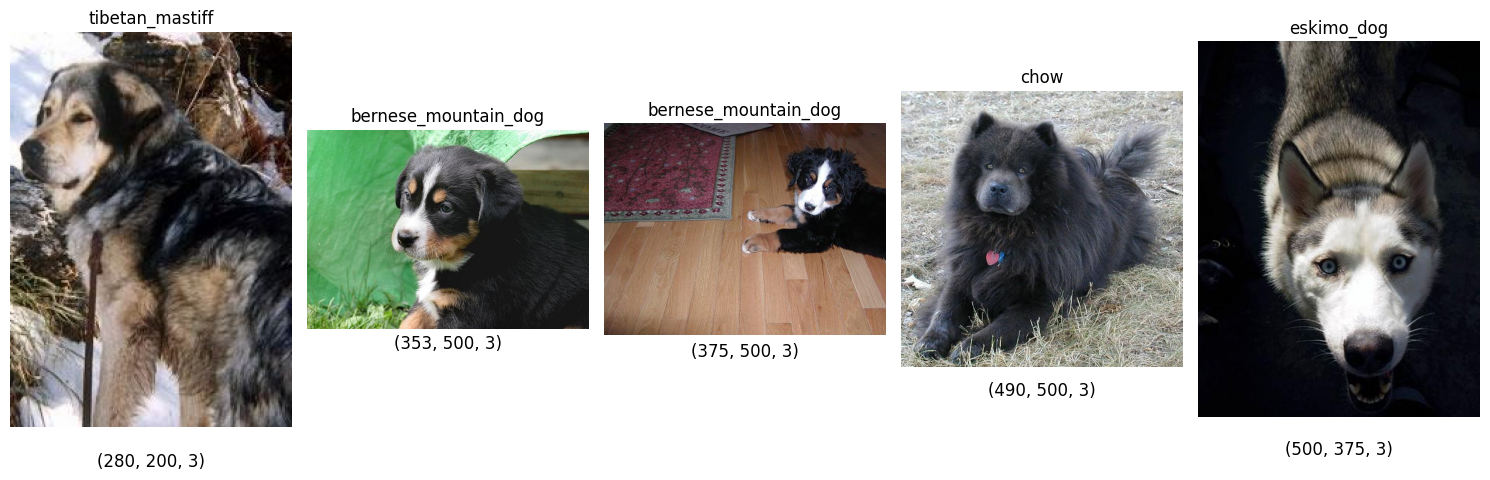

In [ ]:
# Sample images
num_samples = 5
samples = ds.take(num_samples)
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
for ax, sample in zip(axes, samples):
    ax.imshow(sample["image"])
    ax.axis("off")
    ax.set_title(sample["class"], fontsize=12)
    ax.text(0.5, -0.1, np.shape(sample["image"]), fontsize=12, ha="center", transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [ ]:
import IPython
IPython.get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

: 